# Best Beauty Plot ever

In [1]:
import datetime
import numpy as np
import xarray as xr
import netCDF4 as nc4
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from src.utils import modif_plot
from mpl_toolkits.basemap import Basemap

In [3]:
import pyproj
from src.modules.grid.grid import Grid
from src.modules.topaz.v4.confmap import ConformalMapping

In [4]:
from src.data_preparation import load_data
from src.data_preparation import merge_TOPAZ
from src.utils import modif_plot
from src.utils import save_name
from src.utils import tardisml_utils

In [5]:
rootdir = tardisml_utils.get_rootdir()

# Import TOPAZ grid

In [6]:
mtp_proj = pyproj.Proj('+proj=stere +lon_0=-45 +lat_0=90 +k=1 +R=6378273 +no_defs')

In [7]:
ifile = '/scratch/project_465000269/edelleo1/Leo/Jiping_2023/TP4b/20221231_dm-12km-NERSC-MODEL-TOPAZ4B-ARC-RAN.fv2.0.nc'

In [8]:
nc = nc4.Dataset(f'{ifile}', mode='r')
sit = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['sithick']

In [9]:
xt, yt = np.meshgrid(sit.x.to_numpy(), sit.y.to_numpy())

In [10]:
t_grid = Grid(mtp_proj, xt*100000, yt*100000)

## Get area 

In [11]:
area = (t_grid.dx / t_grid.mfx) * (t_grid.dy / t_grid.mfx)

In [12]:
# reshape
area = area[150:629, 100:550]
area = area[::-1]  # flip right side up

# Import SIT

In [13]:
sit_ml, chrono_dt = merge_TOPAZ.load(return_na=False, return_bl=False, return_mean=False)

Import...
Old config files, some <ml> parameters are not imported.
	1991-1998
Old config files, some <ml> parameters are not imported.
	1999-2010
Old config files, some <ml> parameters are not imported.
	2011-2022
Merging...


In [13]:
# sit_nan = (sit_ml.where((0<=sit_ml))).where(np.isfinite(sit_ml))  # exclude open ocean (SIT=0m)

In [14]:
sit_nan = (sit_ml.where((0<sit_ml))).where(np.isfinite(sit_ml))  # exclude open ocean (SIT=0m)

# Compute sea ice volume (SIT*area)

In [15]:
# Repeat area on time axis - not needed
# area_t = area[np.newaxis,:,:].repeat(len(sit_nan.time), axis=0)

In [16]:
volume = np.nansum(sit_nan * area, axis=(1,2)) / 1e9

# Nice variable for volume

In [17]:
xr_vol = xr.DataArray(
    data=volume,
    dims=["time"],
    coords=dict(
        time=(["time"], sit_nan.time.data)    #   <---- or sit_ml
    ),
    attrs=dict(
        name="Sea ice volume",
        description="Sea Ice Thickness * area of original grid",
        units="km³",
        standard_name='Volume',
    ),
)

# Combine 2D Map and SIV time series

In [18]:
odir = f'{rootdir}Leo/results/beauty_best/'

In [19]:
day = datetime.datetime(1993,10,18)

In [20]:
## Comment from visualization workshop
# Change the BLUE curve to another color that evoques sea ice (and that is in the colorbar) > like yellow/pinkish
# space out the 2 subplots, because the first years are masking the Arctic
# increase width of the SIV subplot, so we can read it more easily
# replace SIV plot by "Sea Ice Volume Death Spiral"

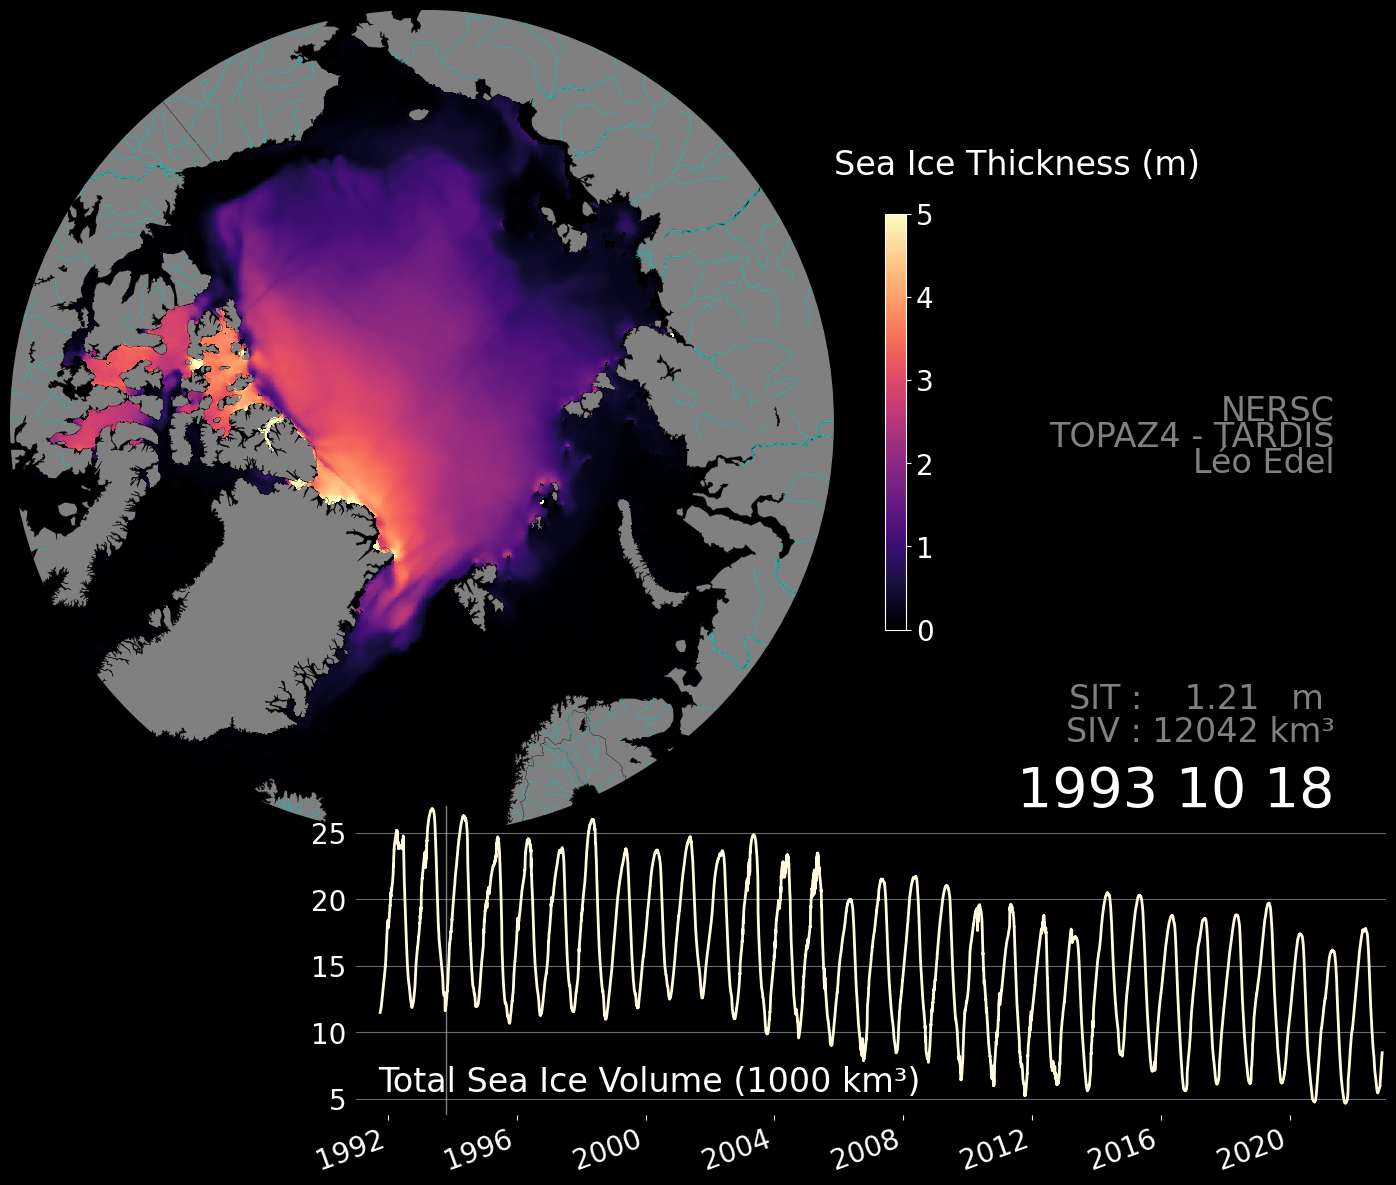

In [ ]:
draw_beauty_plot(sit_nan, xr_vol, day=day, odir=odir, savefig=False)

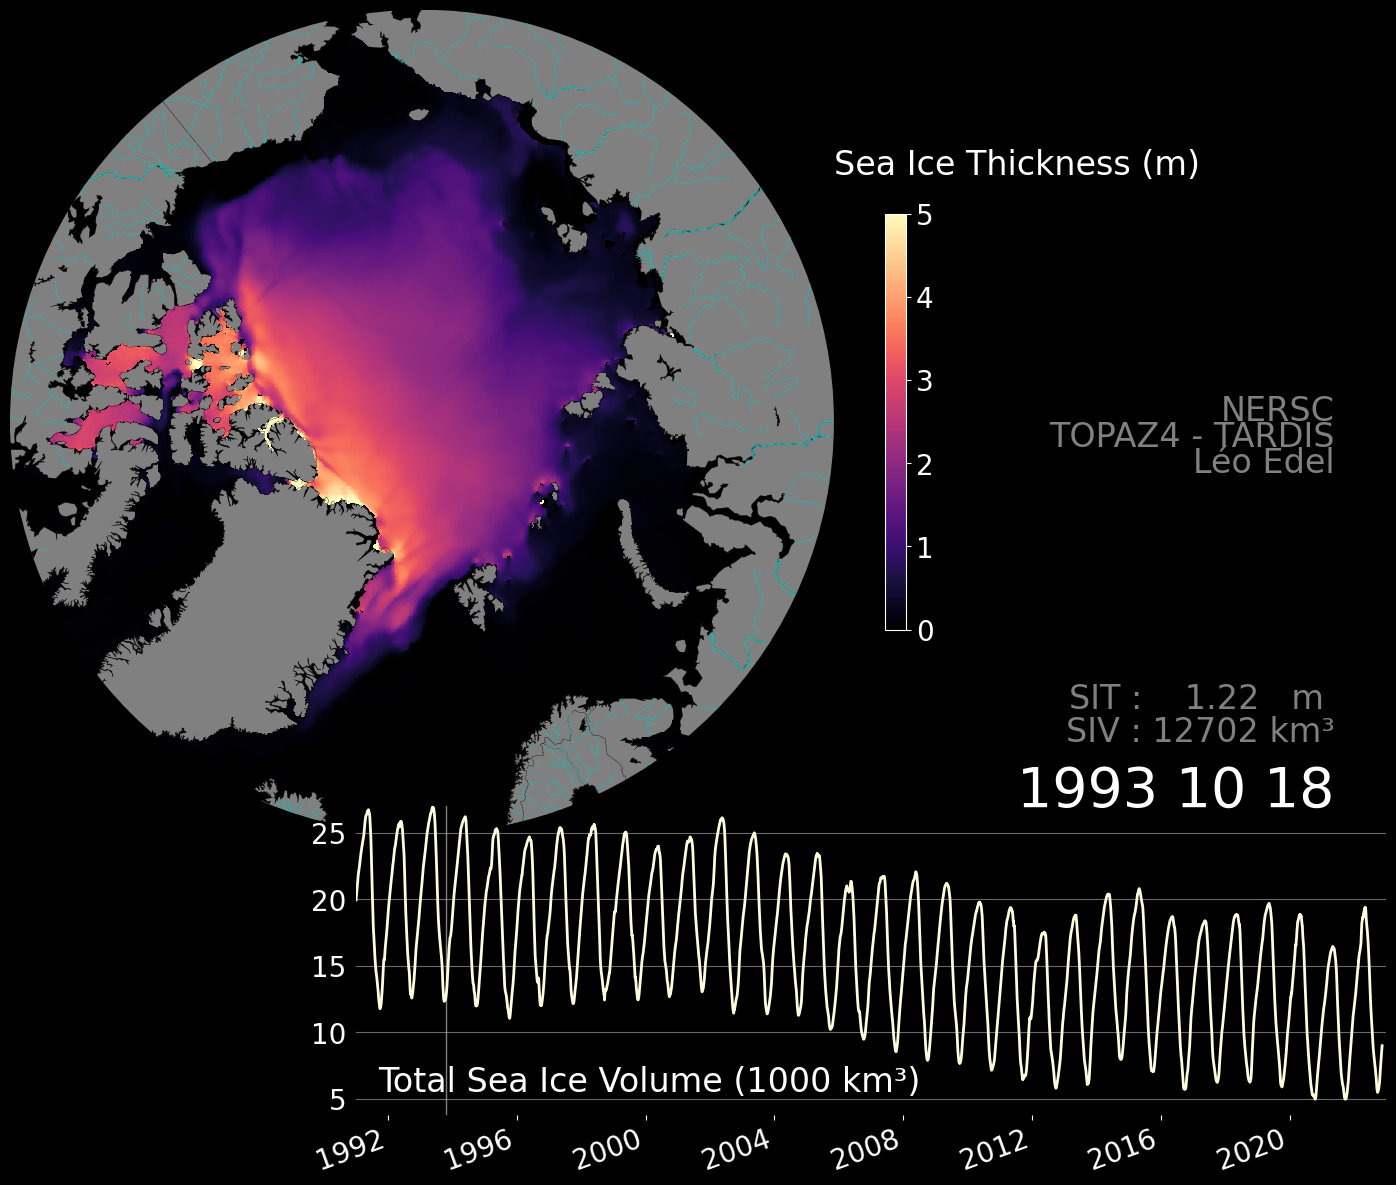

In [30]:
draw_beauty_plot(sit_nan, xr_vol, day=day, odir=odir, savefig=False)

In [142]:
# Ticks in white for black background

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

In [91]:
def draw_beauty_plot(sit, vol, day, odir='', showfig=True, savefig=False):
    '''
    '''
    
    # identify index to plot
    chrono_tp = pd.DataFrame({'date':pd.to_datetime(sit.time.to_numpy())})
    chrono_dt = np.array([dt.date() for dt in chrono_tp.date])
    t_idx = np.where(chrono_dt==day.date())[0][0]
    
    # Draw figure
    fig = plt.figure(figsize=(16*2, 9*2), constrained_layout=False, facecolor='k')
    gs1 = fig.add_gridspec(nrows=8, ncols=8, left=0.05, right=0.48, wspace=0.05)

    ax1 = fig.add_subplot(gs1[:, :6])  # y, x
    ax2 = fig.add_subplot(gs1[6:, 2:])   # [5:, ...]
    
    # -----------------------------
    ## Basemap plot
    
    cmap = plt.get_cmap('magma')  # 'bone')
    m = Basemap(projection='npstere', boundinglat=65, lon_0=0, resolution='l', round=True, ax=ax1)

    # draw coastlines, country boundaries, fill continents.
    m.drawcoastlines(linewidth=0.25)
    m.drawcountries(linewidth=0.25)

    m.fillcontinents(color='grey', lake_color='k')
    m.drawrivers(color='#1EB8B3')  # 26E2DB
    m.drawmapboundary(fill_color='k')

    mlons, mlats = m(sit.longitude.to_numpy(), sit.latitude.to_numpy())
    cm1 = m.pcolormesh(mlons, mlats, sit.isel(time=t_idx).to_numpy(), vmin=0, vmax=5, cmap=cmap)

    cbar = plt.colorbar(cm1, shrink=0.3)  # , label='Sea-ice thickness (m)'
    cbar.set_ticks([0,1,2,3,4,5])

    # Annotate
    ax1.annotate('Sea Ice Thickness (m)', xy=(1,.8), xycoords='axes fraction', color='w', fontsize=24)

    plt.annotate('NERSC', xy=(.95,2.14), xycoords='axes fraction', color='grey', ha='right', fontsize=24)
    plt.annotate('TOPAZ4 - TARDIS', xy=(.95,2.06), xycoords='axes fraction', color='grey', ha='right', fontsize=24)
    plt.annotate('Léo Edel', xy=(.95,1.98), xycoords='axes fraction', color='grey', ha='right', fontsize=24)
    
    ax2.annotate(f'{sit.time.dt.strftime("%Y %m %d").to_numpy()[t_idx]}', xy=(.95,.95),
                 xycoords='axes fraction', ha='right', color='w', fontsize=40)
    
    
    plt.annotate(f'SIT :    {sit.isel(time=t_idx).mean().to_numpy():.2f}   m ', xy=(.95,1.25),
                 xycoords='axes fraction', ha='right', color='grey', fontsize=24)
    plt.annotate(f'SIV : {xr_vol.isel(time=t_idx).to_numpy():.0f} km³', xy=(.95,1.15),
                 xycoords='axes fraction', ha='right', color='grey', fontsize=24)
    
    # -----------------------------
    ## Volume plot

    (vol/1000).plot(ax=ax2, lw=2, color='#fffcdd')  # blue: #1295B2
#     (vol/1000).plot(ax=ax2, lw=3, color='w', zorder=-5)  # just to get white outline
    
    
    ax2.plot([sit.time[t_idx].dt]*2, [3.8,27], lw=1, c='grey', zorder=-10)
    
    ax2.yaxis.grid(alpha=0.6)
    # ax2.xaxis.grid(alpha=0.6)
    # ax2.set_ylabel('Sea Ice Volume (1000 km³)')
    ax2.set_ylabel('')
    ax2.set_xlabel('')
    ax2.spines[['right', 'top', 'left']].set_visible(False)
    ax2.tick_params(left=False)

    ax2.set_frame_on(False)  # remove background
    
    ax2.annotate('Total Sea Ice Volume (1000 km³)', xy=(.0215,.07), xycoords='axes fraction', color='w', fontsize=24)
    

    ax2.set_xlim([datetime.datetime(1991,1,1), datetime.datetime(2022,12,31)])
    ax2.set_ylim([3.8, 28.2])
    
    # -----------------------------
    
    modif_plot.resize(fig, s=20, rx=20, do_annotation=False)
    
    
    ## Save figure
    if savefig:
        sdate = chrono_dt[t_idx].strftime("%Y%m%d")
        ofile = f'SIC_SIV_beautyplot_{sdate}.png'
        ofile = save_name.check(odir, ofile)
        plt.savefig(f"{odir}{ofile}", dpi=150, bbox_inches='tight')
        print(f'Saved as: {odir}{ofile}')

    if showfig:
        plt.show()

    plt.close()    
    

In [21]:
import calendar
import matplotlib.dates as mdates

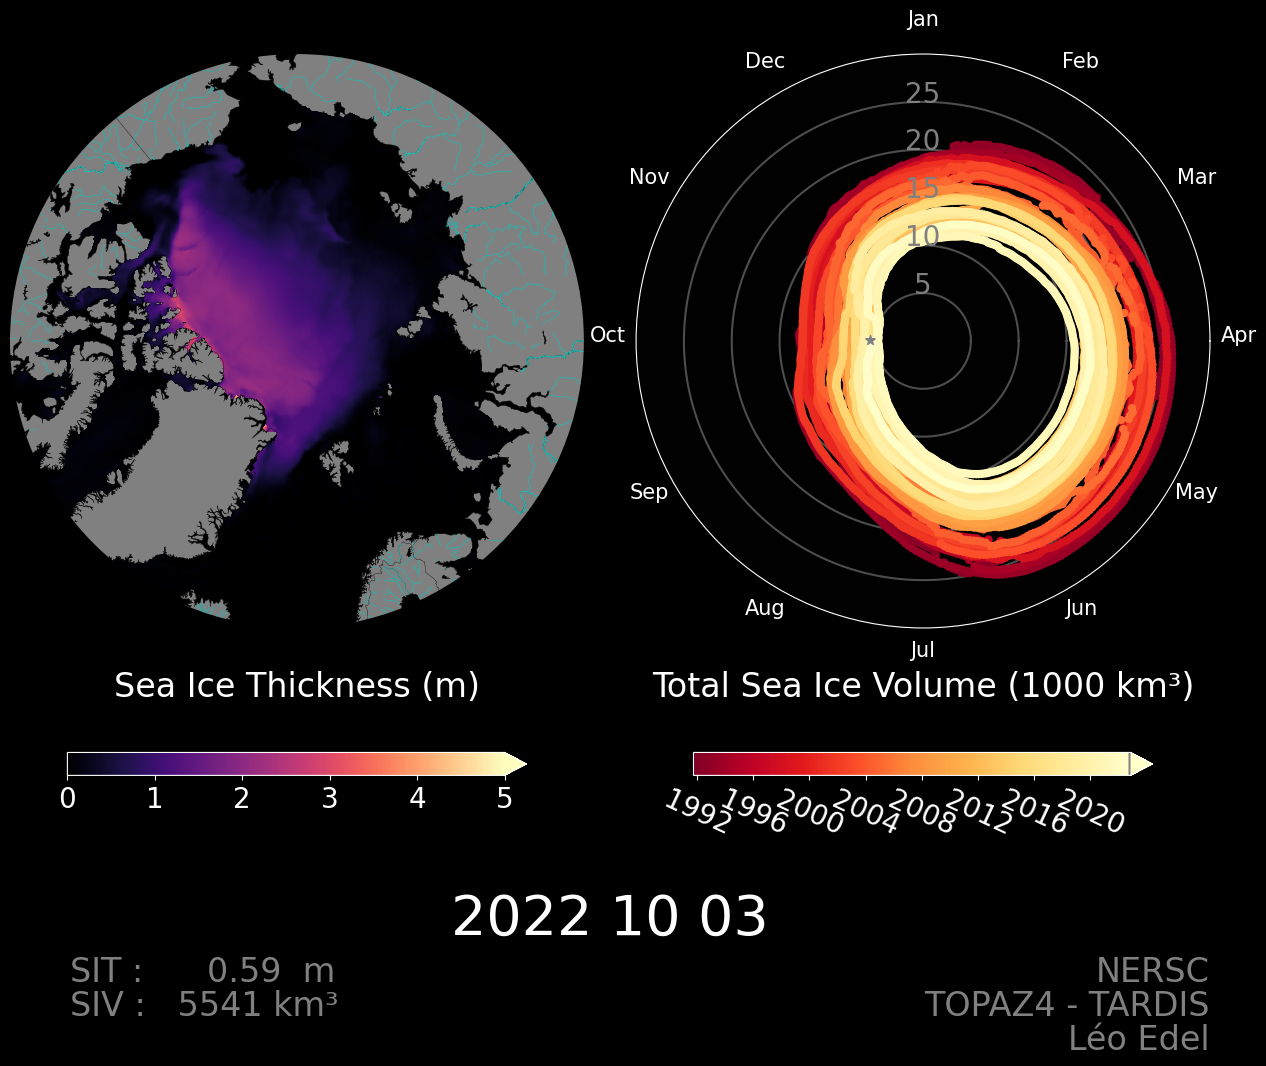

In [200]:
draw_spiral_beauty_plot(sit_nan, xr_vol, day=datetime.datetime(2022,10,3), odir=odir, savefig=False)

In [120]:
# from matplotlib.dates import DateFormatter,DayLocator

In [199]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

def draw_spiral_beauty_plot(sit, vol, day, odir='', showfig=True, savefig=False):
    '''
    '''
    
    # identify index to plot
    chrono_tp = pd.DataFrame({'date':pd.to_datetime(sit.time.to_numpy())})
    chrono_dt = np.array([dt.date() for dt in chrono_tp.date])
    t_idx = np.where(chrono_dt==day.date())[0][0]
    
    # Draw figure
    #fig, axes = plt.subplots(ncols=2, figsize=(16, 9), constrained_layout=True, facecolor='k')
    
    fig = plt.figure(figsize=(16*1.5, 9*1.5), constrained_layout=False, facecolor='k')
    # gs1 = fig.add_gridspec(nrows=20, ncols=8, left=0.05, right=0.48, wspace=0.05)
    gs1 = fig.add_gridspec(nrows=20, ncols=8, left=0.0, right=0.5, wspace=0.5)
    

    ax1 = fig.add_subplot(gs1[:16, :4])  # y, x
#     cax1 = fig.add_subplot(gs1[15:16, 1:3], aspect=.3)
    ax2 = fig.add_subplot(gs1[:16, 4:], projection='polar')
    #cax2 = fig.add_subplot(gs1[15:16, 4:8], aspect=.3)
    
    ax3 = fig.add_subplot(gs1[16:18, :])
    
    ax4 = fig.add_subplot(gs1[18:19, :])
#     cax2.set_visible(False)
    # -----------------------------
    ## Basemap plot
    
    cmap = plt.get_cmap('magma')  # 'bone')
    m = Basemap(projection='npstere', boundinglat=65, lon_0=0, resolution='l', round=True, ax=ax1)

    # draw coastlines, country boundaries, fill continents.
    m.drawcoastlines(linewidth=0.25)
    m.drawcountries(linewidth=0.25)

    m.fillcontinents(color='grey', lake_color='k')
    m.drawrivers(color='#1EB8B3')  # 26E2DB
    m.drawmapboundary(fill_color='k')

    mlons, mlats = m(sit.longitude.to_numpy(), sit.latitude.to_numpy())
    cm1 = m.pcolormesh(mlons, mlats, sit.isel(time=t_idx).to_numpy(), vmin=0, vmax=5, cmap=cmap)

    # COLORBAR
    cbar = fig.colorbar(cm1, ax=ax1, shrink=0.8, orientation='horizontal', extend='max')  # , label='Sea-ice thickness (m)'
    # cax=cax1, shrink=0.2,
    cbar.set_ticks([0,1,2,3,4,5])
    cbar.ax.tick_params(labelsize=20)

    # Annotate
    ax1.annotate('Sea Ice Thickness (m)', xy=(.5,-.12), xycoords='axes fraction', 
                 ha='center', color='w', fontsize=24)

    # -----------------------------
    ## Volume plot
    
    full_circle_thetas = np.linspace(0, 2*np.pi, 366)
    yticks = [5,10,15,20,25]

    # plot volume rings
    for ytick in yticks:
        ax2.plot(full_circle_thetas, [ytick]*366, c='grey', zorder=-10, alpha=0.6)
        ax2.text(np.pi/2, ytick, f'{ytick}', color="grey", ha='center', fontdict={'fontsize': 20})
    
    colors = plt.cm.YlOrRd_r(np.linspace(0, 1, xr_vol.size))
    
    # plot each year with different color
    years = range(1992, 2023)
    yr_max = day.year
    for yr in range(years[0], yr_max):  # plot all full year
        if calendar.isleap(yr):
            ndays = 366  # number of days in year
        else:
            ndays=365

        theta = np.linspace(np.pi/2, -1.5*np.pi, ndays)  # or 366 if bisextil
        first_day = np.where(chrono_dt==datetime.date(yr,1,1))[0][0]
        last_day = np.where(chrono_dt==datetime.date(yr,12,31))[0][0] + 1
        vol_sliced = vol.isel(time=slice(first_day, last_day))
        clrs = colors[first_day:last_day]
        sc2 = ax2.scatter(theta, vol_sliced/1000, color=clrs, s=25)
    
    
    # ------------------ plot current year ---------------------------
    last_yr = day.year
    first_day = np.where(chrono_dt==datetime.date(last_yr,1,1))[0][0]
    last_vol_sliced = vol.isel(time=slice(first_day, t_idx))
    if calendar.isleap(last_yr):
        ndays = 366  # number of days in year
    else:
        ndays=365
    clrs = colors[first_day : first_day+last_vol_sliced.size]

    last_theta = np.linspace(np.pi/2, -1.5*np.pi, ndays)[:last_vol_sliced.shape[0]]
    cm2 = ax2.scatter(last_theta, last_vol_sliced/1000, color=clrs, s=25)
        
    if last_vol_sliced.size == 0 and last_yr==1992:  ## first day of first year
        ax2.scatter(np.pi/2, vol.isel(time=first_day)/1000, color='grey', s=50, marker='*')
    elif last_vol_sliced.size == 0:  ## happen on the first january
        ax2.scatter(theta[-1], vol_sliced[-1]/1000, color='grey', s=50, marker='*')
    else:
        ax2.scatter(last_theta[-1], last_vol_sliced[-1]/1000, color='grey', s=50, marker='*')
    
    # --------------------------------------------------------------
    
    #add months labels
    months=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    months_angles= np.linspace((np.pi/2)+(2*np.pi),np.pi/2,13)
    for i, month in enumerate(months):
        ax2.text(months_angles[i], 33, month, color="white", fontsize=15, ha="center")
    
    
    ax2.yaxis.grid(False)
    ax2.xaxis.grid(False)
    
    ax2.axes.get_yaxis().set_ticklabels([])
    ax2.axes.get_xaxis().set_ticklabels([])
    ax2.set_facecolor('#000100')

    ax2.set_ylim([0, 30])

    # ---------- COLORBAR TIME------------------
    
    
    hline_idx = mdates.date2num(day)
    cc=mdates.date2num(xr_vol.time)
    
    sc2 = ax4.scatter(vol.time, vol/1000, c=cc, cmap=plt.cm.YlOrRd_r)
                         
    cbar2 = fig.colorbar(sc2, ax=ax2, shrink=0.8, orientation='horizontal', extend='max')
    loc = mdates.YearLocator(4)
    cbar2.ax.xaxis.set_major_locator(loc)
    cbar2.ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    cbar2.ax.tick_params(rotation=-25)
    cbar2.ax.hlines(0, hline_idx-25, hline_idx+25, colors='grey', lw=100)
                    
    ax4.set_visible(False)
    
    ax2.annotate('Total Sea Ice Volume (1000 km³)', xy=(.5,-.12), xycoords='axes fraction',
                 ha='center', color='w', fontsize=24)
    
    # -----------------------------
    
    ax3.axis('off')
    
    ax3.annotate('NERSC', xy=(1,0), xycoords='axes fraction', color='grey', ha='right', fontsize=24)
    ax3.annotate('TOPAZ4 - TARDIS', xy=(1, -0.35), xycoords='axes fraction', color='grey', ha='right', fontsize=24)
    ax3.annotate('Léo Edel', xy=(1, -.7), xycoords='axes fraction', color='grey', ha='right', fontsize=24)
    
    ax3.annotate(f'{sit.time.dt.strftime("%Y %m %d").to_numpy()[t_idx]}', xy=(.5,.5),
                 xycoords='axes fraction', ha='center', color='w', fontsize=40)
    
    ax3.annotate(f'SIT :    {sit.isel(time=t_idx).mean().to_numpy():>6.2f}  m', xy=(.05,0),
                 xycoords='axes fraction', ha='left', color='grey', fontsize=24)
    ax3.annotate(f'SIV : {xr_vol.isel(time=t_idx).to_numpy():>6.0f} km³', xy=(.05, -.35),
                 xycoords='axes fraction', ha='left', color='grey', fontsize=24)
    
    # -----------------------------
    
    modif_plot.resize(fig, s=20, rx=20, do_annotation=False)
    
    
    ## Save figure
    if savefig:
        sdate = chrono_dt[t_idx].strftime("%Y%m%d")
        ofile = f'SIC_SIV_beautyplot_{sdate}.png'
        ofile = save_name.check(odir, ofile)
        plt.savefig(f"{odir}{ofile}", dpi=150, bbox_inches='tight')
        print(f'Saved as: {odir}{ofile}')

    if showfig:
        plt.show()

    plt.close()    
    

---------------

## Plot 2D

In [23]:
from src.utils import modif_plot
from mpl_toolkits.basemap import Basemap

In [25]:
# Ticks in white for black background

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

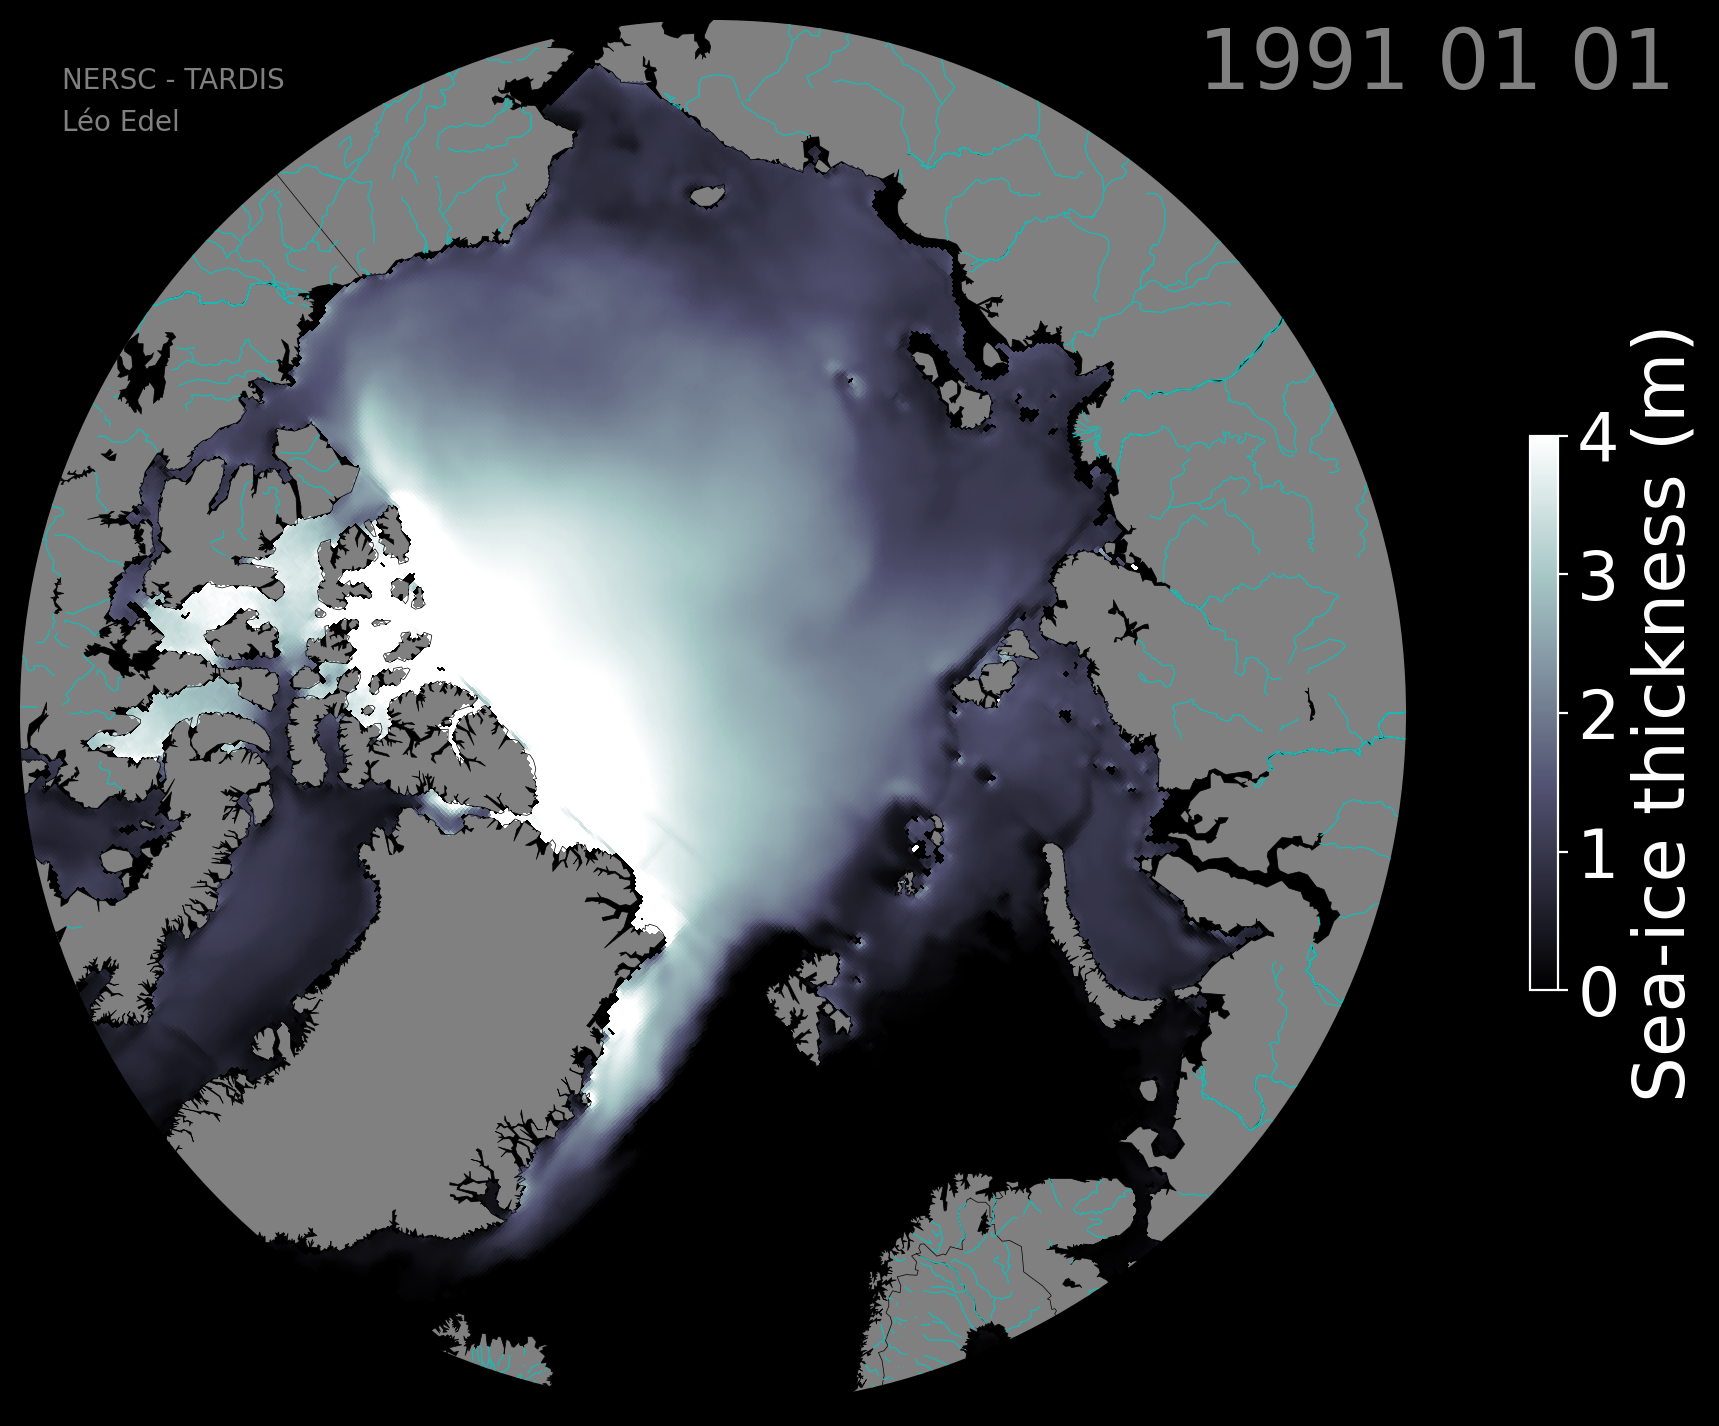

In [83]:
t_idx = 0


fig = plt.figure(figsize=(16, 9), dpi=200, facecolor='k')

cmap = plt.get_cmap('bone')

m = Basemap(projection='npstere', boundinglat=65, lon_0=0, resolution='l', round=True)

# m.bluemarble(scale=.4)


# draw coastlines, country boundaries, fill continents.
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)

# m.fillcontinents(color='coral',lake_color='aqua')
# draw the edge of the m2 projection region (the projection limb)
# draw lat/lon grid lines every 30 degrees.
# m2.drawmeridians(np.arange(0,360,30), color='w')
# m2.drawparallels(np.arange(-90,90,30), color='w')

m.fillcontinents(color='grey', lake_color='k')
m.drawrivers(color='#1EB8B3')  # 26E2DB
# m.shadedrelief()

m.drawmapboundary(fill_color='k')

# m2.scatter(lat, lon, sit, latlon=True)
mlons, mlats = m(sit_nan.longitude.to_numpy(), sit_nan.latitude.to_numpy())
cm1 = m.pcolormesh(mlons, mlats, sit_nan.isel(time=t_idx).to_numpy(), vmin=0, vmax=4, cmap=cmap)

cbar = plt.colorbar(cm1, label='Sea-ice thickness (m)', shrink=0.4)
cbar.set_ticks([0,1,2,3,4])

# Annotate


plt.annotate('NERSC - TARDIS', xy=(.03,.95), xycoords='axes fraction', color='grey')
plt.annotate('Léo Edel', xy=(.03,.92), xycoords='axes fraction', color='grey')

# plt.annotate(f'{sit_nan.time[t_idx].date.strftime("%Y %m %d")}', xy=(.85,.95), xycoords='axes fraction', color='grey', fontsize=30)
plt.annotate(f'{sit_nan.time.dt.strftime("%Y %m %d").to_numpy()[t_idx]}', xy=(.85,.95), xycoords='axes fraction', color='grey', fontsize=30)



modif_plot.resize(fig, s=24)


plt.show()

# Plot SIV

In [60]:
def draw_vol(vol, volm, trends={}, trends_min={}, trends_max={}, odir='', showfig=True, savefig=False):
    '''
    Parameters:
    -----------
    
        vol    :    xarray.DataArray, daily volume 
        volm   :    xarray.DataArray, volume average each month
        trends :    dictionnary, contains trends to plot
    '''
    
    fig, ax = plt.subplots(figsize=(16,9), constrained_layout=True)

    ## Draw volume
    (volm/1000).isel(time=range(4,n_months,12)).plot(ms=15, lw=2, marker='.', color='b', label='May')
    (volm/1000).isel(time=range(9,n_months,12)).plot(ms=15, lw=2, marker='.', color='r', label='Octobre')
    (vol/1000).plot(lw=2, color='k')

    ## Draw trends
    list_trends = list(trends.keys())
    if len(list_trends)>0:
        for n in list_trends:
            plt.plot(trends[n][0], trends[n][1]/1000, c='k', ls='--')
        
    list_trends_min = list(trends_min.keys())
    if len(list_trends_min)>0:
        for n in list_trends_min:
            plt.plot(trends_min[n][0], trends_min[n][1]/1000, c='r', ls='--', marker='+', ms=10)
        
    list_trends_max = list(trends_max.keys())
    if len(list_trends_max)>0:
        for n in list_trends_max:
            plt.plot(trends_max[n][0], trends_max[n][1]/1000, c='b', ls='--', marker='+', ms=10)
        
      
    ax.yaxis.grid(alpha=0.6, ls='-.')
    ax.xaxis.grid(alpha=0.6)
    ax.set_ylabel('Sea Ice Volume (1000 km³)')
    ax.set_xlabel('')
    ax.spines[['right', 'top']].set_visible(False)

    plt.legend(fontsize=18)

    ax.set_xlim([datetime.datetime(1991,1,1), datetime.datetime(2022,12,31)])
    
    modif_plot.resize(fig, s=24)

    if savefig:
        ofile = f'SIV_01.png'
        ofile = save_name.check(odir, ofile)
        plt.savefig(f"{odir}{ofile}", dpi=200, facecolor='white')
        print(f'Saved as: {odir}{ofile}')

    if showfig:
        plt.show()

    plt.close()    
